<a href="https://colab.research.google.com/github/Slax97/VIU-TFM/blob/main/Phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
target = 'phishing'
# 1. Cargar el dataset
df = pd.read_csv("dataset_small.csv")

# Comprobar si hay valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

Valores faltantes por columna:
qty_dot_url             0
qty_hyphen_url          0
qty_underline_url       0
qty_slash_url           0
qty_questionmark_url    0
                       ..
qty_redirects           0
url_google_index        0
domain_google_index     0
url_shortened           0
phishing                0
Length: 112, dtype: int64


In [ ]:
len(df)

58645

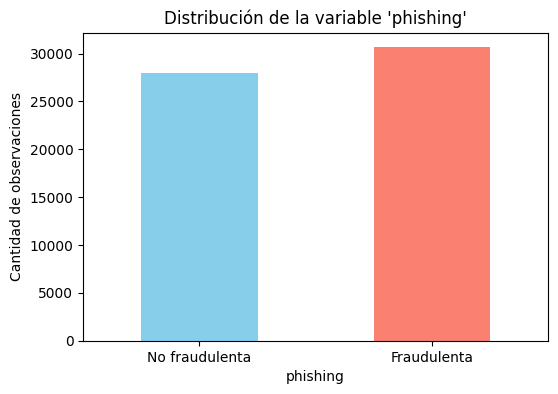

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar el dataset
df = pd.read_csv("dataset_small.csv")

# 2. Contar la cantidad de cada clase en la columna 'phishing'
counts = df['phishing'].value_counts().sort_index()  # Asegura que 0 esté primero y 1 después

# 3. Crear el histograma
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Distribución de la variable 'phishing'")
plt.ylabel("Cantidad de observaciones")
plt.xticks(ticks=[0,1], labels=['No fraudulenta', 'Fraudulenta'], rotation=0)  # Etiquetas personalizadas
plt.show()


In [ ]:
# Eliminar columnas que solo tienen un valor único
df = df.loc[:, df.nunique() > 1]


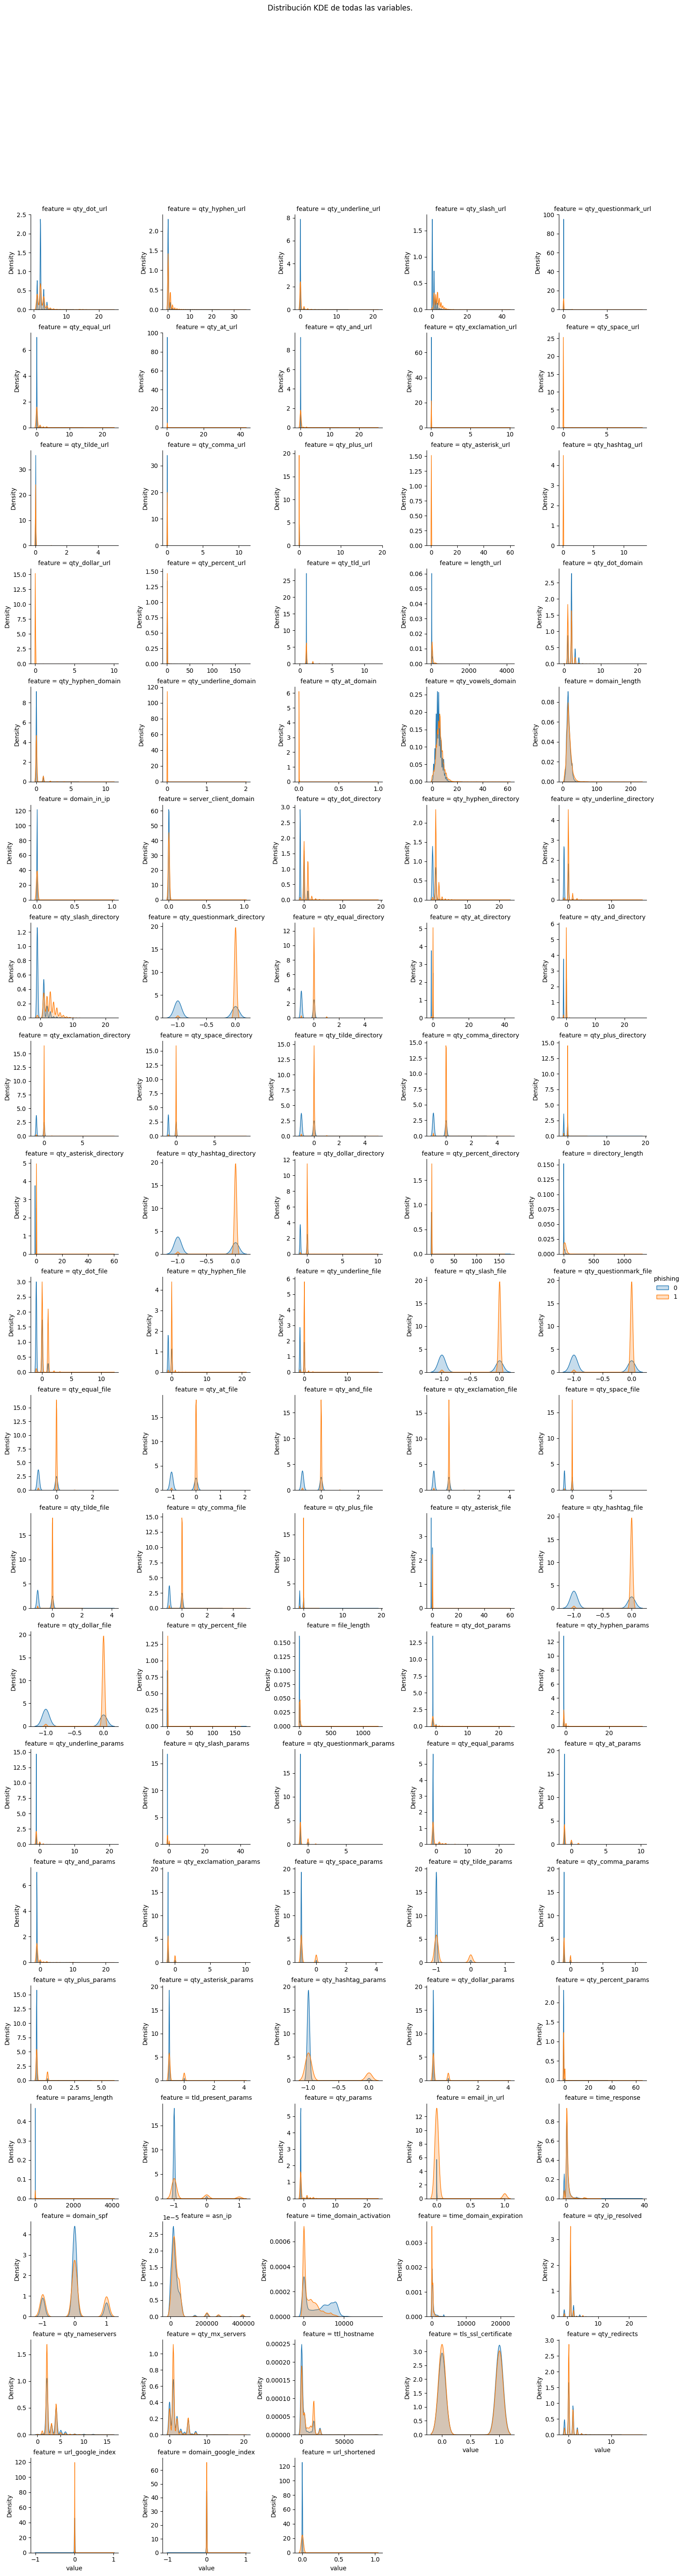

In [ ]:
# Crear grid con KDE para cada variable
df_melt = df.melt(id_vars=target, var_name="feature", value_name="value")

g = sns.FacetGrid(df_melt, col="feature", col_wrap=5, hue=target, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", fill=True, warn_singular=False)  # 👈 aquí va
g.add_legend()

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribución KDE de todas las variables.")
plt.show()

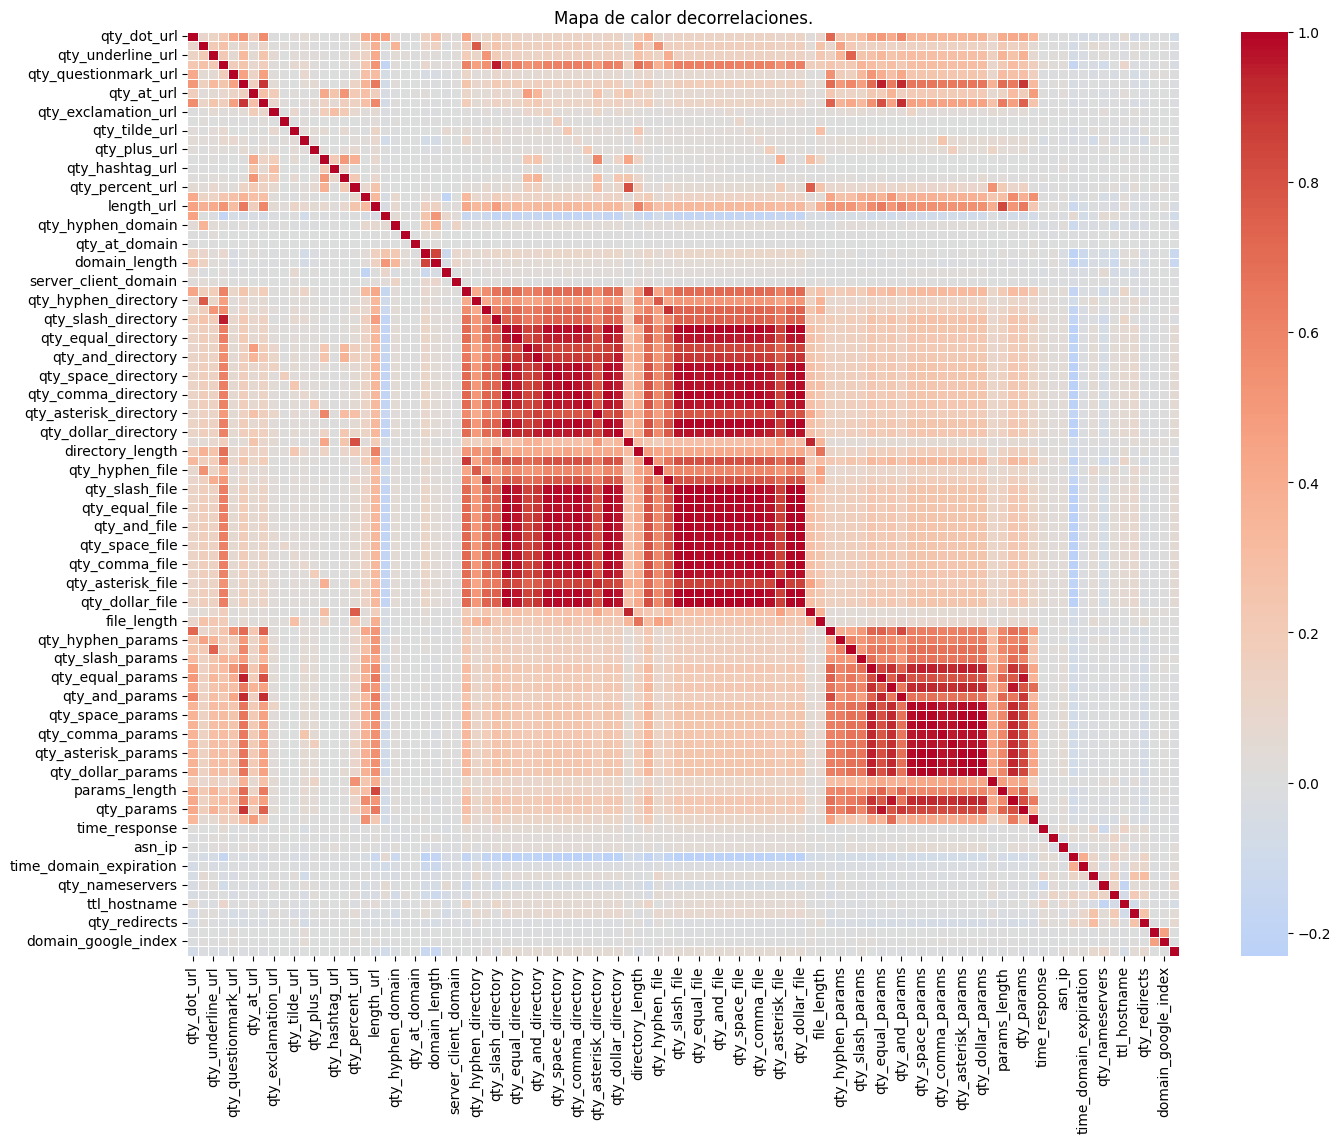

In [ ]:
# Calcular matriz de correlación solo con las variables numéricas
corr = df.drop(columns=target).corr()

# Dibujar heatmap sin números
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5, annot=False)

plt.title( "Mapa de calor decorrelaciones.")
plt.show()


In [ ]:
# 1. Calcular correlación
corr = df.drop(columns=target).corr().abs()  # usamos valor absoluto

# 2. Tomar solo la mitad superior de la matriz
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3. Buscar columnas con correlación >= 0.90
to_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]

print("Columnas a eliminar por alta correlación (>= 0.90):")
print(to_drop)

# 4. Crear dataframe sin esas columnas
df = df.drop(columns=to_drop)


Columnas a eliminar por alta correlación (>= 0.90):
['qty_slash_directory', 'qty_equal_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_hashtag_directory', 'qty_dollar_directory', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file', 'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file', 'qty_percent_file', 'qty_equal_params', 'qty_at_params', 'qty_and_params', 'qty_exclamation_params', 'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params', 'tld_present_params', 'qty_params']


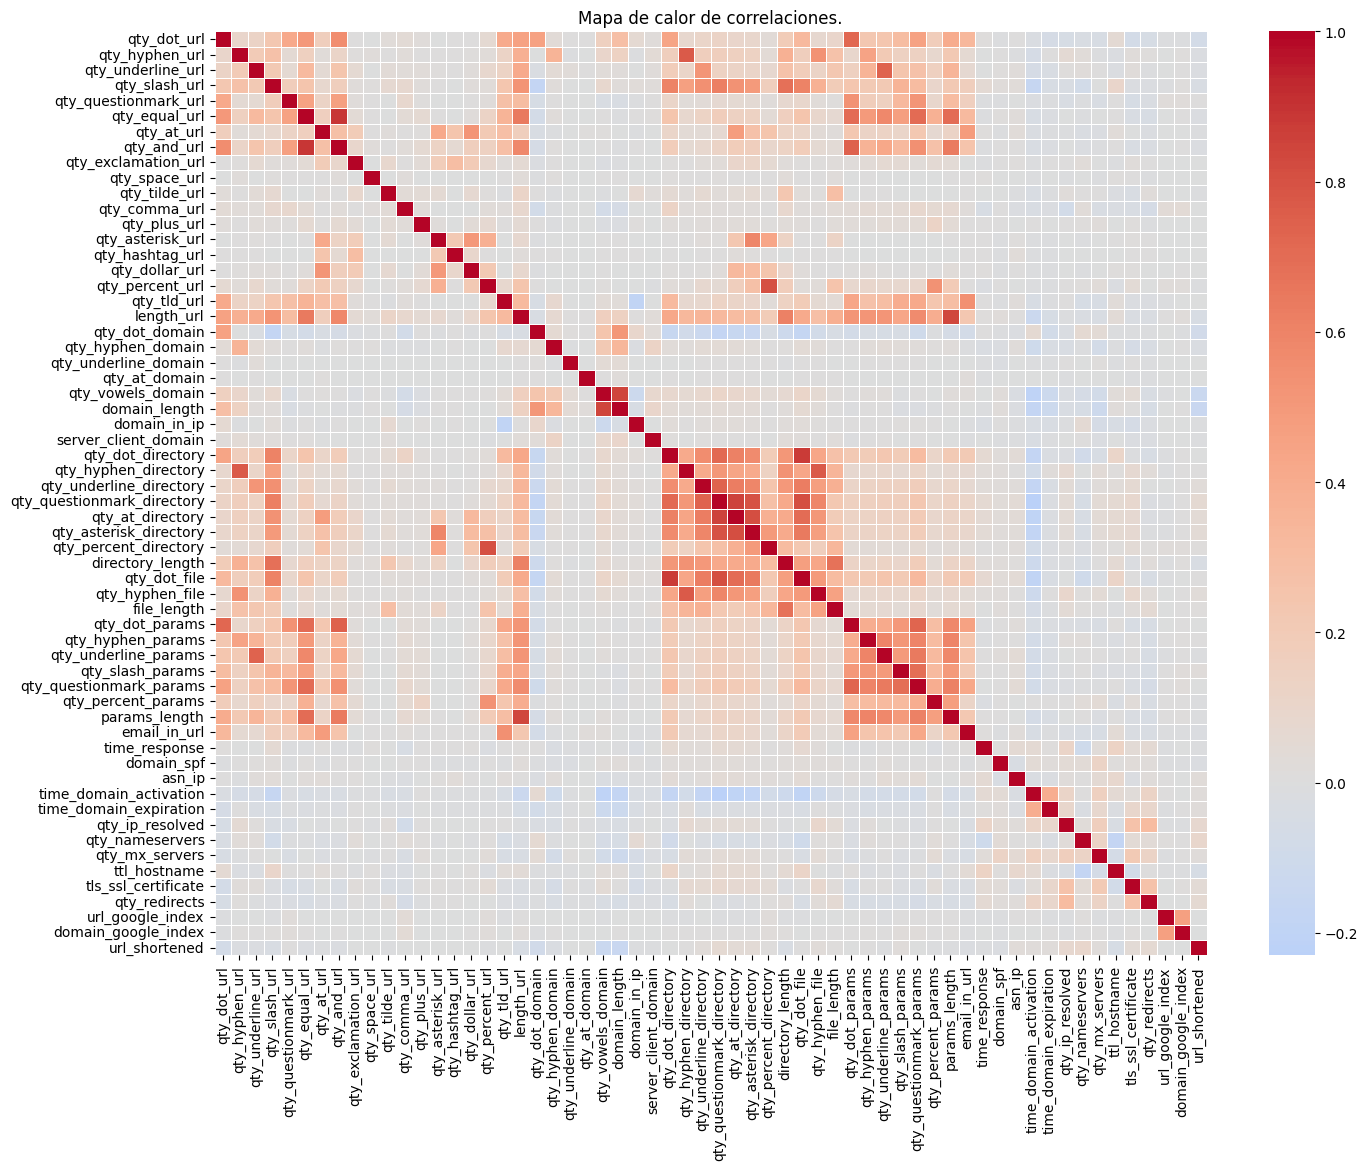

In [ ]:
# Calcular matriz de correlación solo con las variables numéricas
corr = df.drop(columns=target).corr()

# Dibujar heatmap sin números
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5, annot=False)

plt.title("Mapa de calor de correlaciones.")
plt.show()


In [ ]:
X = df.drop(columns=[target])  # todas las columnas menos la de etiquetas
y = df[target]                 # solo la columna de etiquetas


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamaño entrenamiento:", X_train.shape[0])
print("Tamaño test:", X_test.shape[0])

Tamaño entrenamiento: 41051
Tamaño test: 17594


In [ ]:
feature_names = X.columns.tolist()

# Entrenar el MinMaxScaler con TODO el dataset
scaler = MinMaxScaler()
scaler.fit(X)  # 👈 ajuste con todos los datos

# Aplicar la transformación a train y test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame para visualizar
df_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
df_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

print("Train escalado (primeras filas):")
print(df_train_scaled.head())

print("\nTest escalado (primeras filas):")
print(df_test_scaled.head())

Train escalado (primeras filas):
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0     0.000000             0.0           0.000000       0.068182   
1     0.043478             0.0           0.000000       0.022727   
2     0.086957             0.0           0.095238       0.045455   
3     0.000000             0.0           0.000000       0.000000   
4     0.043478             0.0           0.000000       0.000000   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                   0.0            0.0         0.0          0.0   
1                   0.0            0.0         0.0          0.0   
2                   0.0            0.0         0.0          0.0   
3                   0.0            0.0         0.0          0.0   
4                   0.0            0.0         0.0          0.0   

   qty_exclamation_url  qty_space_url  ...  time_domain_expiration  \
0                  0.0            0.0  ...                0.012802   
1              

Train Decision Tree DecisionTreeClassifier(random_state=42)
Train Random Forest RandomForestClassifier(random_state=42)
Train SVM SVC(probability=True, random_state=42)
Train Naive Bayes GaussianNB()
Train Gradient Boosting GradientBoostingClassifier(random_state=42)
Train Logistic Regression LogisticRegression(max_iter=1000, random_state=42)
Train KNN KNeighborsClassifier()
Train MLP MLPClassifier(max_iter=500, random_state=42)

Resultados en Validación Cruzada (media):
                Modelo  Accuracy (CV)  Precision (CV)  Recall (CV)  \
0        Decision Tree       0.927992        0.927828     0.927887   
1        Random Forest       0.954666        0.954763     0.954385   
2                  SVM       0.895155        0.897829     0.893358   
3          Naive Bayes       0.612214        0.733477     0.627698   
4    Gradient Boosting       0.933717        0.933803     0.933352   
5  Logistic Regression       0.885435        0.888373     0.883492   
6                  KNN       0.920

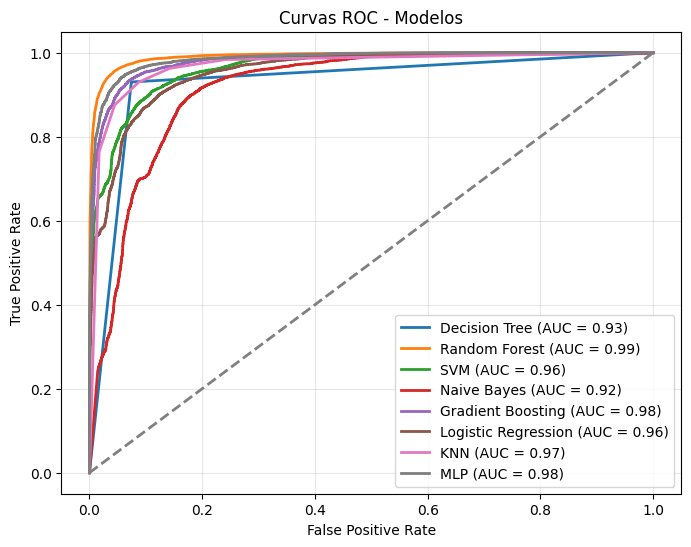


=== Resultados en Test: Decision Tree ===


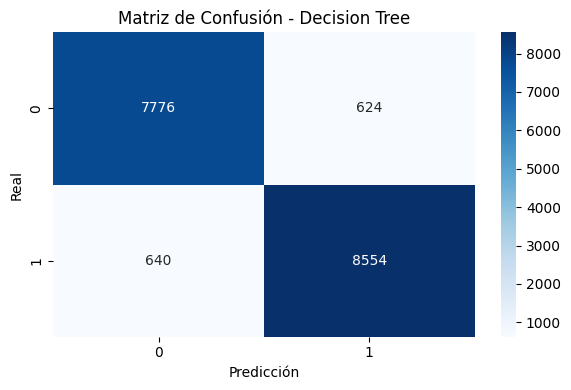


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      8400
           1       0.93      0.93      0.93      9194

    accuracy                           0.93     17594
   macro avg       0.93      0.93      0.93     17594
weighted avg       0.93      0.93      0.93     17594


=== Resultados en Test: Random Forest ===


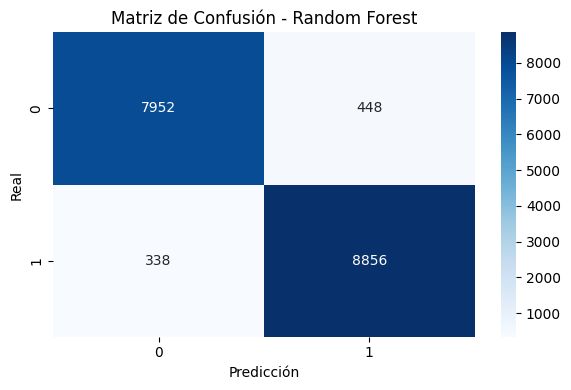


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      8400
           1       0.95      0.96      0.96      9194

    accuracy                           0.96     17594
   macro avg       0.96      0.95      0.96     17594
weighted avg       0.96      0.96      0.96     17594


=== Resultados en Test: SVM ===


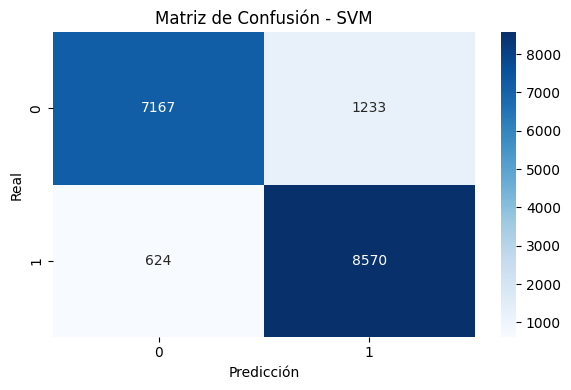


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      8400
           1       0.87      0.93      0.90      9194

    accuracy                           0.89     17594
   macro avg       0.90      0.89      0.89     17594
weighted avg       0.90      0.89      0.89     17594


=== Resultados en Test: Naive Bayes ===


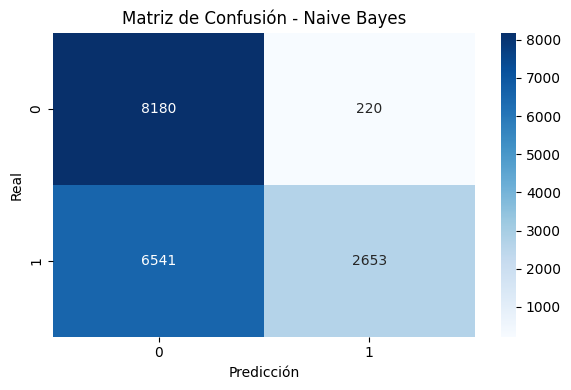


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.56      0.97      0.71      8400
           1       0.92      0.29      0.44      9194

    accuracy                           0.62     17594
   macro avg       0.74      0.63      0.57     17594
weighted avg       0.75      0.62      0.57     17594


=== Resultados en Test: Gradient Boosting ===


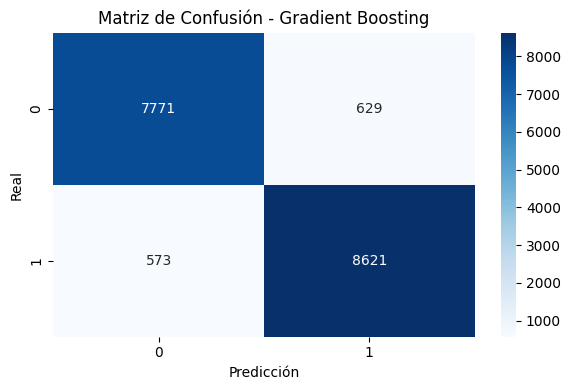


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8400
           1       0.93      0.94      0.93      9194

    accuracy                           0.93     17594
   macro avg       0.93      0.93      0.93     17594
weighted avg       0.93      0.93      0.93     17594


=== Resultados en Test: Logistic Regression ===


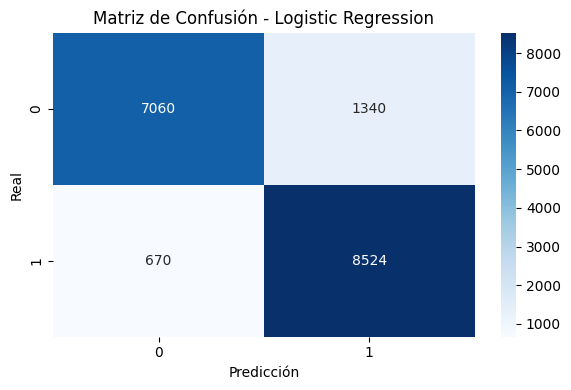


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      8400
           1       0.86      0.93      0.89      9194

    accuracy                           0.89     17594
   macro avg       0.89      0.88      0.88     17594
weighted avg       0.89      0.89      0.89     17594


=== Resultados en Test: KNN ===


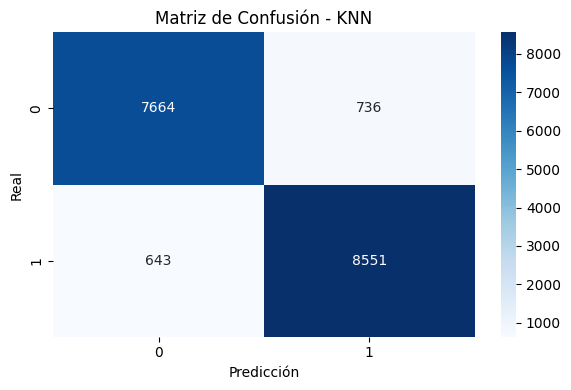


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      8400
           1       0.92      0.93      0.93      9194

    accuracy                           0.92     17594
   macro avg       0.92      0.92      0.92     17594
weighted avg       0.92      0.92      0.92     17594


=== Resultados en Test: MLP ===


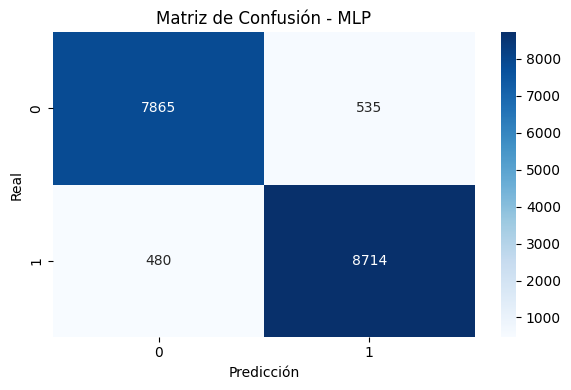


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8400
           1       0.94      0.95      0.94      9194

    accuracy                           0.94     17594
   macro avg       0.94      0.94      0.94     17594
weighted avg       0.94      0.94      0.94     17594



In [ ]:
# =====================================================
# 1. Definir modelos
# =====================================================
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),  # activamos predict_proba
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# =====================================================
# 2. Validación cruzada con varias métricas
# =====================================================
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
results = []

for name, model in models.items():
    print(f'Train {name} {model}')
    scores = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scoring)
    results.append({
        "Modelo": name,
        "Accuracy (CV)": scores["test_accuracy"].mean(),
        "Precision (CV)": scores["test_precision_macro"].mean(),
        "Recall (CV)": scores["test_recall_macro"].mean(),
        "F1-score (CV)": scores["test_f1_macro"].mean()
    })

df_results = pd.DataFrame(results)
print("\nResultados en Validación Cruzada (media):")
print(df_results)

# =====================================================
# 3. Evaluación en test final
# =====================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =====================================================
# 3. Evaluación en test final (guardamos predicciones)
# =====================================================
final_results = []
predictions = {}  # para guardar y_pred de cada modelo

for name, model in models.items():
    print(f'Test {name} {model}')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred  # guardamos las predicciones

    final_results.append({
        "Modelo": name,
        "Accuracy Test": accuracy_score(y_test, y_pred),
        "Precision Test": precision_score(y_test, y_pred, average="macro"),
        "Recall Test": recall_score(y_test, y_pred, average="macro"),
        "F1-score Test": f1_score(y_test, y_pred, average="macro")
    })

df_final = pd.DataFrame(final_results)
print("\nResultados en Test:")
print(df_final)

# =====================================================
# 4. Mejor modelo por cada métrica en Test
# =====================================================
best_by_metric = {}
for metric in ["Accuracy Test", "Precision Test", "Recall Test", "F1-score Test"]:
    best_model = df_final.loc[df_final[metric].idxmax(), "Modelo"]
    best_score = df_final[metric].max()
    best_by_metric[metric] = (best_model, best_score)

print("\nMejores modelos por métrica (Test):")
for metric, (model, score) in best_by_metric.items():
    print(f"{metric}: {model} ({score:.4f})")

# =====================================================
# 5. Función para matriz de confusión
# =====================================================
def plot_confusion_matrix(y_test, y_pred, class_names=None, title="Matriz de Confusión"):
    cm = confusion_matrix(y_test, y_pred)

    if class_names is None:
        class_names = [str(c) for c in sorted(set(y_test))]  # nombres automáticos

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=class_names))

# =====================================================
# 6. Curvas ROC (solo para binario)
# =====================================================
plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_score = model.decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC - Modelos")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# =====================================================
# Matriz de confusión y clasificación para cada algoritmo
# =====================================================
for model_name, y_pred in predictions.items():
    print(f"\n=== Resultados en Test: {model_name} ===")
    plot_confusion_matrix(y_test, y_pred, title=f"Matriz de Confusión - {model_name}")
